# Semantic Enhancement of Prithvi via Knowledge Distillation from RemoteCLIP

## Two-Phase Approach:
- **Phase 1**: Unsupervised Alignment - Train projection head to map Prithvi features to RemoteCLIP semantic space
- **Phase 2**: Supervised Evaluation - Compare baseline vs semantically-enhanced models via linear probing

**Dataset**: NWPU-RESISC45 (45 classes, 31,500 images)

## 1. Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from pathlib import Path
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU


## 2. Load Teacher Model: RemoteCLIP (Frozen)

In [2]:
# Install RemoteCLIP dependencies if not already installed
!pip install huggingface_hub open_clip_torch
!git clone https://github.com/ChenDelong1999/RemoteCLIP/

fatal: destination path 'RemoteCLIP' already exists and is not an empty directory.


In [3]:
from huggingface_hub import hf_hub_download
import open_clip

# Download RemoteCLIP ViT-B/32
model_name = 'ViT-B-32'
checkpoint_path = hf_hub_download("chendelong/RemoteCLIP", f"RemoteCLIP-{model_name}.pt", cache_dir='checkpoints')
print(f'RemoteCLIP {model_name} downloaded to: {checkpoint_path}')

# Load RemoteCLIP (the warning about "No pretrained weights" is expected - we load them manually next)
print("\nCreating model architecture...")
remoteclip_model, _, remoteclip_preprocess = open_clip.create_model_and_transforms(model_name)

# Load the RemoteCLIP checkpoint
print("Loading RemoteCLIP pretrained weights...")
path_to_checkpoints = 'checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38'
ckpt = torch.load(f"{path_to_checkpoints}/RemoteCLIP-{model_name}.pt", map_location="cpu")

# Verify the checkpoint loaded correctly
print(f"Checkpoint keys: {len(ckpt.keys())} parameters")

# Load weights into model
load_result = remoteclip_model.load_state_dict(ckpt)
print(f"Load result: {load_result}")

# Move to device and set to eval mode
remoteclip_model = remoteclip_model.to(device).eval()

# Freeze RemoteCLIP (Teacher is frozen)
for param in remoteclip_model.parameters():
    param.requires_grad = False

# Verify model is working by checking if it has learned weights
sample_param = next(remoteclip_model.parameters())
print(f"\nSample weight stats: mean={sample_param.mean().item():.4f}, std={sample_param.std().item():.4f}")
print(f"✅ RemoteCLIP loaded successfully and frozen. Output dimension: 512")

c:\Users\prana\Downloads\VIII-Sem-MP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RemoteCLIP ViT-B-32 downloaded to: checkpoints\models--chendelong--RemoteCLIP\snapshots\bf1d8a3ccf2ddbf7c875705e46373bfe542bce38\RemoteCLIP-ViT-B-32.pt

Creating model architecture...


Loading RemoteCLIP pretrained weights...
Checkpoint keys: 302 parameters
Load result: <All keys matched successfully>

Sample weight stats: mean=-0.0002, std=0.0071
✅ RemoteCLIP loaded successfully and frozen. Output dimension: 512


## 3. Load Student Backbone: Prithvi EO v2 (Frozen)

In [4]:
from terratorch.registry import BACKBONE_REGISTRY

# Load Prithvi backbone
prithvi_backbone = BACKBONE_REGISTRY.build("prithvi_eo_v2_300")
prithvi_backbone = prithvi_backbone.to(device).eval()

# Freeze Prithvi (we only train the projection head)
for param in prithvi_backbone.parameters():
    param.requires_grad = False

print(f"✅ Prithvi EO v2 loaded and frozen. Output dimension: 1024")

✅ Prithvi EO v2 loaded and frozen. Output dimension: 1024


## 4. Define Projection Head (Trainable in Phase 1)

In [5]:
class ProjectionHead(nn.Module):
    """
    2-layer MLP: Maps Prithvi features (1024-dim) to RemoteCLIP space (512-dim)
    """
    def __init__(self, input_dim=1024, hidden_dim=768, output_dim=512):
        super(ProjectionHead, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

projection_head = ProjectionHead(input_dim=1024, hidden_dim=768, output_dim=512).to(device)
print(f"✅ Projection Head created: 1024 → 768 → 512")
print(f"Trainable parameters: {sum(p.numel() for p in projection_head.parameters()):,}")

✅ Projection Head created: 1024 → 768 → 512
Trainable parameters: 1,180,928


## 5. Dataset for Phase 1: Unsupervised Alignment (No Labels)

In [6]:
class UnsupervisedImageDataset(Dataset):
    """
    Dataset that returns images without labels for knowledge distillation
    """
    def __init__(self, root_dir, prithvi_transform, remoteclip_transform):
        self.root_dir = Path(root_dir)
        self.prithvi_transform = prithvi_transform
        self.remoteclip_transform = remoteclip_transform
        
        # Collect all image paths (no labels needed)
        self.image_paths = []
        for class_dir in self.root_dir.iterdir():
            if class_dir.is_dir():
                for img_path in class_dir.glob('*.jpg'):
                    self.image_paths.append(str(img_path))
        
        print(f"Found {len(self.image_paths)} images for unsupervised alignment")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Apply both transforms
        prithvi_img = self.prithvi_transform(image)
        remoteclip_img = self.remoteclip_transform(image)
        
        return prithvi_img, remoteclip_img

# Define transforms
prithvi_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# RemoteCLIP has its own preprocessing
unsupervised_dataset = UnsupervisedImageDataset(
    'Dataset/train/train',
    prithvi_transform=prithvi_transform,
    remoteclip_transform=remoteclip_preprocess
)

unsupervised_loader = DataLoader(
    unsupervised_dataset, 
    batch_size=64, 
    shuffle=True, 
    num_workers=0, 
    pin_memory=True
)

print(f"Unsupervised batches: {len(unsupervised_loader)}")

Found 27000 images for unsupervised alignment
Unsupervised batches: 422


## 6. PHASE 1: Knowledge Distillation Training

In [7]:
def extract_prithvi_features(backbone, images):
    """Extract CLS token from Prithvi (1024-dim)"""
    # Convert RGB (3-ch) to 6-ch by zero-padding
    if images.shape[1] == 3:
        images = torch.cat([images, torch.zeros_like(images)], dim=1)
    
    with torch.no_grad():
        features = backbone(images)
        cls_token = features[-1][:, 0, :]  # [batch, 1024]
    return cls_token

def extract_remoteclip_features(model, images):
    """Extract image features from RemoteCLIP (512-dim)"""
    with torch.no_grad():
        features = model.encode_image(images)
        features = features / features.norm(dim=-1, keepdim=True)  # L2 normalize
    return features

# Cosine Embedding Loss for alignment
def cosine_embedding_loss(student_features, teacher_features):
    """
    Loss = 1 - cosine_similarity(student, teacher)
    """
    # L2 normalize
    student_norm = student_features / student_features.norm(dim=-1, keepdim=True)
    teacher_norm = teacher_features / teacher_features.norm(dim=-1, keepdim=True)
    
    # Cosine similarity
    cosine_sim = (student_norm * teacher_norm).sum(dim=1)
    
    # Loss: maximize cosine similarity = minimize (1 - cosine_sim)
    loss = (1 - cosine_sim).mean()
    return loss

In [8]:
# Training configuration for Phase 1
phase1_epochs = 15
phase1_optimizer = optim.AdamW(projection_head.parameters(), lr=1e-3, weight_decay=0.01)
phase1_scheduler = optim.lr_scheduler.CosineAnnealingLR(phase1_optimizer, T_max=phase1_epochs, eta_min=1e-6)

phase1_history = {'loss': [], 'cosine_sim': []}
best_phase1_loss = float('inf')

print("=" * 70)
print("PHASE 1: UNSUPERVISED ALIGNMENT (Knowledge Distillation)")
print("=" * 70)
print(f"Objective: Train Projection Head to align Prithvi features with RemoteCLIP")
print(f"Teacher: RemoteCLIP (frozen)")
print(f"Student: Prithvi + Projection Head (only PH trainable)")
print(f"Loss: Cosine Embedding Loss")
print(f"Epochs: {phase1_epochs}")
print("=" * 70)

PHASE 1: UNSUPERVISED ALIGNMENT (Knowledge Distillation)
Objective: Train Projection Head to align Prithvi features with RemoteCLIP
Teacher: RemoteCLIP (frozen)
Student: Prithvi + Projection Head (only PH trainable)
Loss: Cosine Embedding Loss
Epochs: 15


In [9]:
# Phase 1 Training Loop
for epoch in range(phase1_epochs):
    projection_head.train()
    epoch_loss = 0.0
    epoch_cosine_sim = 0.0
    
    print(f"\n{'='*70}")
    print(f"EPOCH {epoch+1}/{phase1_epochs}")
    print('='*70)
    
    with tqdm(unsupervised_loader, desc='🔄 Distillation', ncols=100) as pbar:
        for batch_idx, (prithvi_imgs, remoteclip_imgs) in enumerate(pbar):
            prithvi_imgs = prithvi_imgs.to(device)
            remoteclip_imgs = remoteclip_imgs.to(device)
            
            # Extract features from frozen models
            prithvi_features = extract_prithvi_features(prithvi_backbone, prithvi_imgs)  # [B, 1024]
            teacher_features = extract_remoteclip_features(remoteclip_model, remoteclip_imgs)  # [B, 512]
            
            # Project Prithvi features to RemoteCLIP space
            student_features = projection_head(prithvi_features)  # [B, 512]
            
            # Compute loss
            loss = cosine_embedding_loss(student_features, teacher_features)
            
            # Backward pass
            phase1_optimizer.zero_grad()
            loss.backward()
            phase1_optimizer.step()
            
            # Track metrics
            epoch_loss += loss.item()
            
            # Calculate average cosine similarity for monitoring
            with torch.no_grad():
                student_norm = student_features / student_features.norm(dim=-1, keepdim=True)
                teacher_norm = teacher_features / teacher_features.norm(dim=-1, keepdim=True)
                cosine_sim = (student_norm * teacher_norm).sum(dim=1).mean().item()
                epoch_cosine_sim += cosine_sim
            
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'CosSim': f'{cosine_sim:.4f}'
            })
    
    # Update scheduler
    phase1_scheduler.step()
    
    # Calculate epoch metrics
    avg_loss = epoch_loss / len(unsupervised_loader)
    avg_cosine_sim = epoch_cosine_sim / len(unsupervised_loader)
    
    phase1_history['loss'].append(avg_loss)
    phase1_history['cosine_sim'].append(avg_cosine_sim)
    
    print(f"\n{'─'*70}")
    print(f"📊 EPOCH {epoch+1} SUMMARY:")
    print(f"  Avg Loss: {avg_loss:.4f}")
    print(f"  Avg Cosine Similarity: {avg_cosine_sim:.4f}")
    print(f"  Learning Rate: {phase1_optimizer.param_groups[0]['lr']:.6f}")
    print(f"{'─'*70}")
    
    # Save best model
    if avg_loss < best_phase1_loss:
        best_phase1_loss = avg_loss
        torch.save({
            'epoch': epoch,
            'projection_head_state_dict': projection_head.state_dict(),
            'optimizer_state_dict': phase1_optimizer.state_dict(),
            'loss': best_phase1_loss,
            'cosine_sim': avg_cosine_sim
        }, 'best_projection_head.pth')
        print(f"✅ Saved best projection head (Loss: {best_phase1_loss:.4f})")

print("\n" + "=" * 70)
print(f"🎉 PHASE 1 COMPLETED! Best Loss: {best_phase1_loss:.4f}")
print("=" * 70)


EPOCH 1/15


🔄 Distillation: 100%|████████████████| 422/422 [14:59<00:00,  2.13s/it, Loss=0.2198, CosSim=0.7802]



──────────────────────────────────────────────────────────────────────
📊 EPOCH 1 SUMMARY:
  Avg Loss: 0.2388
  Avg Cosine Similarity: 0.7612
  Learning Rate: 0.000989
──────────────────────────────────────────────────────────────────────
✅ Saved best projection head (Loss: 0.2388)

EPOCH 2/15


🔄 Distillation: 100%|████████████████| 422/422 [09:09<00:00,  1.30s/it, Loss=0.2081, CosSim=0.7919]



──────────────────────────────────────────────────────────────────────
📊 EPOCH 2 SUMMARY:
  Avg Loss: 0.2148
  Avg Cosine Similarity: 0.7852
  Learning Rate: 0.000957
──────────────────────────────────────────────────────────────────────
✅ Saved best projection head (Loss: 0.2148)

EPOCH 3/15


🔄 Distillation: 100%|████████████████| 422/422 [09:08<00:00,  1.30s/it, Loss=0.2020, CosSim=0.7980]



──────────────────────────────────────────────────────────────────────
📊 EPOCH 3 SUMMARY:
  Avg Loss: 0.2087
  Avg Cosine Similarity: 0.7913
  Learning Rate: 0.000905
──────────────────────────────────────────────────────────────────────
✅ Saved best projection head (Loss: 0.2087)

EPOCH 4/15


🔄 Distillation: 100%|████████████████| 422/422 [09:09<00:00,  1.30s/it, Loss=0.2207, CosSim=0.7793]



──────────────────────────────────────────────────────────────────────
📊 EPOCH 4 SUMMARY:
  Avg Loss: 0.2049
  Avg Cosine Similarity: 0.7951
  Learning Rate: 0.000835
──────────────────────────────────────────────────────────────────────
✅ Saved best projection head (Loss: 0.2049)

EPOCH 5/15


🔄 Distillation: 100%|████████████████| 422/422 [09:08<00:00,  1.30s/it, Loss=0.2113, CosSim=0.7887]



──────────────────────────────────────────────────────────────────────
📊 EPOCH 5 SUMMARY:
  Avg Loss: 0.2025
  Avg Cosine Similarity: 0.7975
  Learning Rate: 0.000750
──────────────────────────────────────────────────────────────────────
✅ Saved best projection head (Loss: 0.2025)

EPOCH 6/15


🔄 Distillation: 100%|████████████████| 422/422 [09:08<00:00,  1.30s/it, Loss=0.1989, CosSim=0.8011]



──────────────────────────────────────────────────────────────────────
📊 EPOCH 6 SUMMARY:
  Avg Loss: 0.2000
  Avg Cosine Similarity: 0.8000
  Learning Rate: 0.000655
──────────────────────────────────────────────────────────────────────
✅ Saved best projection head (Loss: 0.2000)

EPOCH 7/15


🔄 Distillation: 100%|████████████████| 422/422 [09:09<00:00,  1.30s/it, Loss=0.1908, CosSim=0.8092]



──────────────────────────────────────────────────────────────────────
📊 EPOCH 7 SUMMARY:
  Avg Loss: 0.1977
  Avg Cosine Similarity: 0.8023
  Learning Rate: 0.000553
──────────────────────────────────────────────────────────────────────
✅ Saved best projection head (Loss: 0.1977)

EPOCH 8/15


🔄 Distillation: 100%|████████████████| 422/422 [09:08<00:00,  1.30s/it, Loss=0.2033, CosSim=0.7967]



──────────────────────────────────────────────────────────────────────
📊 EPOCH 8 SUMMARY:
  Avg Loss: 0.1957
  Avg Cosine Similarity: 0.8043
  Learning Rate: 0.000448
──────────────────────────────────────────────────────────────────────
✅ Saved best projection head (Loss: 0.1957)

EPOCH 9/15


🔄 Distillation: 100%|████████████████| 422/422 [09:08<00:00,  1.30s/it, Loss=0.1953, CosSim=0.8047]



──────────────────────────────────────────────────────────────────────
📊 EPOCH 9 SUMMARY:
  Avg Loss: 0.1937
  Avg Cosine Similarity: 0.8063
  Learning Rate: 0.000346
──────────────────────────────────────────────────────────────────────
✅ Saved best projection head (Loss: 0.1937)

EPOCH 10/15


🔄 Distillation: 100%|████████████████| 422/422 [09:08<00:00,  1.30s/it, Loss=0.1907, CosSim=0.8093]



──────────────────────────────────────────────────────────────────────
📊 EPOCH 10 SUMMARY:
  Avg Loss: 0.1918
  Avg Cosine Similarity: 0.8082
  Learning Rate: 0.000251
──────────────────────────────────────────────────────────────────────
✅ Saved best projection head (Loss: 0.1918)

EPOCH 11/15


🔄 Distillation: 100%|████████████████| 422/422 [14:35<00:00,  2.07s/it, Loss=0.1916, CosSim=0.8084]



──────────────────────────────────────────────────────────────────────
📊 EPOCH 11 SUMMARY:
  Avg Loss: 0.1897
  Avg Cosine Similarity: 0.8103
  Learning Rate: 0.000166
──────────────────────────────────────────────────────────────────────
✅ Saved best projection head (Loss: 0.1897)

EPOCH 12/15


🔄 Distillation: 100%|████████████████| 422/422 [09:25<00:00,  1.34s/it, Loss=0.1990, CosSim=0.8010]



──────────────────────────────────────────────────────────────────────
📊 EPOCH 12 SUMMARY:
  Avg Loss: 0.1878
  Avg Cosine Similarity: 0.8122
  Learning Rate: 0.000096
──────────────────────────────────────────────────────────────────────
✅ Saved best projection head (Loss: 0.1878)

EPOCH 13/15


🔄 Distillation: 100%|████████████████| 422/422 [09:08<00:00,  1.30s/it, Loss=0.1708, CosSim=0.8292]



──────────────────────────────────────────────────────────────────────
📊 EPOCH 13 SUMMARY:
  Avg Loss: 0.1865
  Avg Cosine Similarity: 0.8135
  Learning Rate: 0.000044
──────────────────────────────────────────────────────────────────────
✅ Saved best projection head (Loss: 0.1865)

EPOCH 14/15


🔄 Distillation: 100%|████████████████| 422/422 [09:08<00:00,  1.30s/it, Loss=0.1897, CosSim=0.8103]



──────────────────────────────────────────────────────────────────────
📊 EPOCH 14 SUMMARY:
  Avg Loss: 0.1852
  Avg Cosine Similarity: 0.8148
  Learning Rate: 0.000012
──────────────────────────────────────────────────────────────────────
✅ Saved best projection head (Loss: 0.1852)

EPOCH 15/15


🔄 Distillation: 100%|████████████████| 422/422 [09:08<00:00,  1.30s/it, Loss=0.1817, CosSim=0.8183]


──────────────────────────────────────────────────────────────────────
📊 EPOCH 15 SUMMARY:
  Avg Loss: 0.1846
  Avg Cosine Similarity: 0.8154
  Learning Rate: 0.000001
──────────────────────────────────────────────────────────────────────
✅ Saved best projection head (Loss: 0.1846)

🎉 PHASE 1 COMPLETED! Best Loss: 0.1846


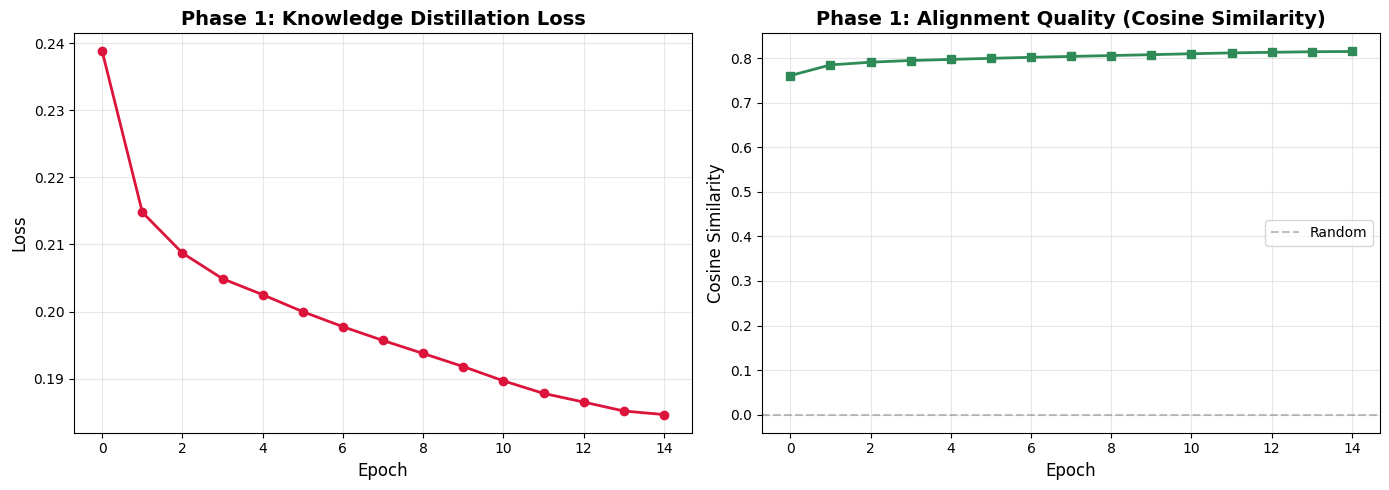

In [10]:
# Visualize Phase 1 Training
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
axes[0].plot(phase1_history['loss'], marker='o', color='crimson', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Phase 1: Knowledge Distillation Loss', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot cosine similarity
axes[1].plot(phase1_history['cosine_sim'], marker='s', color='seagreen', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Cosine Similarity', fontsize=12)
axes[1].set_title('Phase 1: Alignment Quality (Cosine Similarity)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0.0, color='gray', linestyle='--', alpha=0.5, label='Random')
axes[1].legend()

plt.tight_layout()
plt.show()

## 7. Load Best Projection Head and Prepare for Phase 2

In [11]:
# Load best projection head
checkpoint = torch.load('best_projection_head.pth')
projection_head.load_state_dict(checkpoint['projection_head_state_dict'])
projection_head.eval()

# Freeze projection head for Phase 2
for param in projection_head.parameters():
    param.requires_grad = False

print(f"✅ Loaded best projection head from epoch {checkpoint['epoch']+1}")
print(f"   Final Loss: {checkpoint['loss']:.4f}")
print(f"   Final Cosine Similarity: {checkpoint['cosine_sim']:.4f}")

✅ Loaded best projection head from epoch 15
   Final Loss: 0.1846
   Final Cosine Similarity: 0.8154


## 8. Dataset for Phase 2: Supervised Classification (With Labels)

In [12]:
class SupervisedImageDataset(Dataset):
    """
    Dataset that returns images with labels for classification
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        
        # Collect all image paths with labels
        self.samples = []
        for class_name in self.classes:
            class_dir = self.root_dir / class_name
            for img_path in class_dir.glob('*.jpg'):
                self.samples.append((str(img_path), self.class_to_idx[class_name]))
        
        print(f"Found {len(self.samples)} images across {len(self.classes)} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transforms for Phase 2
train_transform_phase2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform_phase2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset_phase2 = SupervisedImageDataset('Dataset/train/train', transform=train_transform_phase2)
test_dataset_phase2 = SupervisedImageDataset('Dataset/test/test', transform=test_transform_phase2)

# Create data loaders
batch_size_phase2 = 32
train_loader_phase2 = DataLoader(train_dataset_phase2, batch_size=batch_size_phase2, shuffle=True, num_workers=0, pin_memory=True)
test_loader_phase2 = DataLoader(test_dataset_phase2, batch_size=batch_size_phase2, shuffle=False, num_workers=0, pin_memory=True)

print(f"\nPhase 2 Data:")
print(f"  Classes: {len(train_dataset_phase2.classes)}")
print(f"  Train samples: {len(train_dataset_phase2)}")
print(f"  Test samples: {len(test_dataset_phase2)}")
print(f"  Train batches: {len(train_loader_phase2)}")
print(f"  Test batches: {len(test_loader_phase2)}")

Found 27000 images across 45 classes
Found 4500 images across 45 classes

Phase 2 Data:
  Classes: 45
  Train samples: 27000
  Test samples: 4500
  Train batches: 844
  Test batches: 141


## 9. Define Models for Phase 2: Linear Probing

### Model A (Baseline): Prithvi → Linear Classifier
**Input**: Raw Prithvi features (1024-dim)

### Model B (Ours): Prithvi → Projection Head → Linear Classifier
**Input**: Semantically aligned features (512-dim)

In [13]:
class ModelA_Baseline(nn.Module):
    """
    Baseline: Prithvi (frozen) → Linear Classifier
    Uses raw Prithvi features (1024-dim)
    """
    def __init__(self, backbone, num_classes):
        super(ModelA_Baseline, self).__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        # Convert RGB to 6-channel
        if x.shape[1] == 3:
            x = torch.cat([x, torch.zeros_like(x)], dim=1)
        
        # Extract features (frozen)
        with torch.no_grad():
            features = self.backbone(x)
            cls_token = features[-1][:, 0, :]  # [batch, 1024]
        
        # Classify
        logits = self.classifier(cls_token)
        return logits

class ModelB_SemanticEnhanced(nn.Module):
    """
    Our Method: Prithvi (frozen) → Projection Head (frozen) → Linear Classifier
    Uses semantically aligned features (512-dim)
    """
    def __init__(self, backbone, projection_head, num_classes):
        super(ModelB_SemanticEnhanced, self).__init__()
        self.backbone = backbone
        self.projection_head = projection_head
        self.classifier = nn.Linear(512, num_classes)
    
    def forward(self, x):
        # Convert RGB to 6-channel
        if x.shape[1] == 3:
            x = torch.cat([x, torch.zeros_like(x)], dim=1)
        
        # Extract features (frozen)
        with torch.no_grad():
            features = self.backbone(x)
            cls_token = features[-1][:, 0, :]  # [batch, 1024]
            
            # Project to semantic space (frozen)
            semantic_features = self.projection_head(cls_token)  # [batch, 512]
        
        # Classify
        logits = self.classifier(semantic_features)
        return logits

# Create both models
num_classes = len(train_dataset_phase2.classes)

model_a = ModelA_Baseline(prithvi_backbone, num_classes).to(device)
model_b = ModelB_SemanticEnhanced(prithvi_backbone, projection_head, num_classes).to(device)

print("=" * 70)
print("PHASE 2: LINEAR PROBING COMPARISON")
print("=" * 70)
print(f"\n📊 Model A (Baseline):")
print(f"   Architecture: Prithvi(frozen) → Linear(1024→{num_classes})")
print(f"   Trainable params: {sum(p.numel() for p in model_a.parameters() if p.requires_grad):,}")

print(f"\n🚀 Model B (Semantic-Enhanced):")
print(f"   Architecture: Prithvi(frozen) → PH(frozen) → Linear(512→{num_classes})")
print(f"   Trainable params: {sum(p.numel() for p in model_b.parameters() if p.requires_grad):,}")
print("=" * 70)

PHASE 2: LINEAR PROBING COMPARISON

📊 Model A (Baseline):
   Architecture: Prithvi(frozen) → Linear(1024→45)
   Trainable params: 46,125

🚀 Model B (Semantic-Enhanced):
   Architecture: Prithvi(frozen) → PH(frozen) → Linear(512→45)
   Trainable params: 23,085


## 10. Training Functions for Phase 2

In [14]:
def train_linear_probe(model, train_loader, test_loader, num_epochs=20, lr=1e-3, model_name="Model"):
    """
    Train a linear probe on frozen features
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    
    print(f"\n{'='*70}")
    print(f"Training {model_name}")
    print('='*70)
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', ncols=100) as pbar:
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                train_total += labels.size(0)
                train_correct += predicted.eq(labels).sum().item()
                
                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100.*train_correct/train_total:.2f}%'
                })
        
        train_loss /= len(train_loader)
        train_acc = 100. * train_correct / train_total
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_loss /= len(test_loader)
        val_acc = 100. * val_correct / val_total
        
        # Update scheduler
        scheduler.step()
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print summary
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}% | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Track best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
    
    print(f"\n✅ Best Validation Accuracy: {best_val_acc:.2f}%")
    print('='*70)
    
    return history, best_val_acc

## 11. Train Model A (Baseline)

In [15]:
history_a, best_acc_a = train_linear_probe(
    model_a, 
    train_loader_phase2, 
    test_loader_phase2, 
    num_epochs=20, 
    lr=1e-3,
    model_name="Model A (Baseline)"
)


Training Model A (Baseline)


Epoch 1/20 [Train]: 100%|████████████████| 844/844 [07:48<00:00,  1.80it/s, Loss=3.0018, Acc=18.96%]


Epoch 1/20 | Train Loss: 3.0585 Acc: 18.96% | Val Loss: 2.8615 Acc: 22.38% | LR: 0.000994


Epoch 2/20 [Train]: 100%|████████████████| 844/844 [07:49<00:00,  1.80it/s, Loss=2.9653, Acc=23.69%]


Epoch 2/20 | Train Loss: 2.8106 Acc: 23.69% | Val Loss: 2.8449 Acc: 22.20% | LR: 0.000976


Epoch 3/20 [Train]: 100%|████████████████| 844/844 [07:49<00:00,  1.80it/s, Loss=2.5809, Acc=25.52%]


Epoch 3/20 | Train Loss: 2.7124 Acc: 25.52% | Val Loss: 2.7978 Acc: 22.64% | LR: 0.000946


Epoch 4/20 [Train]: 100%|████████████████| 844/844 [07:49<00:00,  1.80it/s, Loss=2.4591, Acc=26.86%]


Epoch 4/20 | Train Loss: 2.6490 Acc: 26.86% | Val Loss: 2.6445 Acc: 26.78% | LR: 0.000905


Epoch 5/20 [Train]: 100%|████████████████| 844/844 [07:49<00:00,  1.80it/s, Loss=2.4075, Acc=28.06%]


Epoch 5/20 | Train Loss: 2.6013 Acc: 28.06% | Val Loss: 2.5767 Acc: 27.38% | LR: 0.000854


Epoch 6/20 [Train]: 100%|████████████████| 844/844 [07:49<00:00,  1.80it/s, Loss=2.9278, Acc=28.89%]


Epoch 6/20 | Train Loss: 2.5579 Acc: 28.89% | Val Loss: 2.5921 Acc: 26.60% | LR: 0.000794


Epoch 7/20 [Train]: 100%|████████████████| 844/844 [07:49<00:00,  1.80it/s, Loss=2.5549, Acc=29.75%]


Epoch 7/20 | Train Loss: 2.5099 Acc: 29.75% | Val Loss: 2.5671 Acc: 27.73% | LR: 0.000727


Epoch 8/20 [Train]: 100%|████████████████| 844/844 [07:49<00:00,  1.80it/s, Loss=2.1324, Acc=30.31%]


Epoch 8/20 | Train Loss: 2.4876 Acc: 30.31% | Val Loss: 2.5049 Acc: 28.73% | LR: 0.000655


Epoch 9/20 [Train]: 100%|████████████████| 844/844 [07:49<00:00,  1.80it/s, Loss=2.2657, Acc=31.60%]


Epoch 9/20 | Train Loss: 2.4412 Acc: 31.60% | Val Loss: 2.4420 Acc: 30.44% | LR: 0.000579


Epoch 10/20 [Train]: 100%|███████████████| 844/844 [07:48<00:00,  1.80it/s, Loss=2.7928, Acc=32.30%]


Epoch 10/20 | Train Loss: 2.4139 Acc: 32.30% | Val Loss: 2.4613 Acc: 30.87% | LR: 0.000501


Epoch 11/20 [Train]: 100%|███████████████| 844/844 [07:48<00:00,  1.80it/s, Loss=2.2679, Acc=33.11%]


Epoch 11/20 | Train Loss: 2.3883 Acc: 33.11% | Val Loss: 2.4052 Acc: 31.89% | LR: 0.000422


Epoch 12/20 [Train]: 100%|███████████████| 844/844 [07:48<00:00,  1.80it/s, Loss=2.1392, Acc=33.39%]


Epoch 12/20 | Train Loss: 2.3602 Acc: 33.39% | Val Loss: 2.3716 Acc: 34.13% | LR: 0.000346


Epoch 13/20 [Train]: 100%|███████████████| 844/844 [07:49<00:00,  1.80it/s, Loss=2.2645, Acc=34.33%]


Epoch 13/20 | Train Loss: 2.3352 Acc: 34.33% | Val Loss: 2.3751 Acc: 33.53% | LR: 0.000274


Epoch 14/20 [Train]: 100%|███████████████| 844/844 [07:49<00:00,  1.80it/s, Loss=1.8816, Acc=34.76%]


Epoch 14/20 | Train Loss: 2.3166 Acc: 34.76% | Val Loss: 2.4003 Acc: 32.11% | LR: 0.000207


Epoch 15/20 [Train]: 100%|███████████████| 844/844 [07:49<00:00,  1.80it/s, Loss=2.5101, Acc=35.63%]


Epoch 15/20 | Train Loss: 2.2950 Acc: 35.63% | Val Loss: 2.3422 Acc: 34.42% | LR: 0.000147


Epoch 16/20 [Train]: 100%|███████████████| 844/844 [07:49<00:00,  1.80it/s, Loss=2.1155, Acc=36.33%]


Epoch 16/20 | Train Loss: 2.2814 Acc: 36.33% | Val Loss: 2.3396 Acc: 34.04% | LR: 0.000096


Epoch 17/20 [Train]: 100%|███████████████| 844/844 [07:49<00:00,  1.80it/s, Loss=1.7932, Acc=36.52%]


Epoch 17/20 | Train Loss: 2.2671 Acc: 36.52% | Val Loss: 2.3130 Acc: 35.67% | LR: 0.000055


Epoch 18/20 [Train]: 100%|███████████████| 844/844 [07:48<00:00,  1.80it/s, Loss=2.2924, Acc=37.31%]


Epoch 18/20 | Train Loss: 2.2581 Acc: 37.31% | Val Loss: 2.3282 Acc: 34.31% | LR: 0.000025


Epoch 19/20 [Train]: 100%|███████████████| 844/844 [07:49<00:00,  1.80it/s, Loss=1.8873, Acc=37.75%]


Epoch 19/20 | Train Loss: 2.2488 Acc: 37.75% | Val Loss: 2.3012 Acc: 35.71% | LR: 0.000007


Epoch 20/20 [Train]: 100%|███████████████| 844/844 [07:49<00:00,  1.80it/s, Loss=2.2456, Acc=37.89%]


Epoch 20/20 | Train Loss: 2.2447 Acc: 37.89% | Val Loss: 2.3001 Acc: 35.78% | LR: 0.000001

✅ Best Validation Accuracy: 35.78%


## 12. Train Model B (Semantic-Enhanced)

In [16]:
history_b, best_acc_b = train_linear_probe(
    model_b, 
    train_loader_phase2, 
    test_loader_phase2, 
    num_epochs=20, 
    lr=1e-3,
    model_name="Model B (Semantic-Enhanced)"
)


Training Model B (Semantic-Enhanced)


Epoch 1/20 [Train]: 100%|████████████████| 844/844 [07:49<00:00,  1.80it/s, Loss=2.1196, Acc=31.57%]


Epoch 1/20 | Train Loss: 2.5975 Acc: 31.57% | Val Loss: 2.4285 Acc: 36.82% | LR: 0.000994


Epoch 2/20 [Train]: 100%|████████████████| 844/844 [07:49<00:00,  1.80it/s, Loss=2.4022, Acc=35.10%]


Epoch 2/20 | Train Loss: 2.3841 Acc: 35.10% | Val Loss: 2.4170 Acc: 36.58% | LR: 0.000976


Epoch 3/20 [Train]: 100%|████████████████| 844/844 [07:48<00:00,  1.80it/s, Loss=2.3217, Acc=35.92%]


Epoch 3/20 | Train Loss: 2.3296 Acc: 35.92% | Val Loss: 2.3976 Acc: 36.42% | LR: 0.000946


Epoch 4/20 [Train]: 100%|████████████████| 844/844 [07:48<00:00,  1.80it/s, Loss=1.8694, Acc=36.43%]


Epoch 4/20 | Train Loss: 2.2990 Acc: 36.43% | Val Loss: 2.3559 Acc: 36.89% | LR: 0.000905


Epoch 5/20 [Train]: 100%|████████████████| 844/844 [07:48<00:00,  1.80it/s, Loss=2.5356, Acc=36.70%]


Epoch 5/20 | Train Loss: 2.2783 Acc: 36.70% | Val Loss: 2.3595 Acc: 37.84% | LR: 0.000854


Epoch 6/20 [Train]: 100%|████████████████| 844/844 [07:48<00:00,  1.80it/s, Loss=2.2156, Acc=37.21%]


Epoch 6/20 | Train Loss: 2.2533 Acc: 37.21% | Val Loss: 2.3604 Acc: 36.98% | LR: 0.000794


Epoch 7/20 [Train]: 100%|████████████████| 844/844 [07:48<00:00,  1.80it/s, Loss=1.7387, Acc=37.64%]


Epoch 7/20 | Train Loss: 2.2389 Acc: 37.64% | Val Loss: 2.2884 Acc: 38.40% | LR: 0.000727


Epoch 8/20 [Train]: 100%|████████████████| 844/844 [07:48<00:00,  1.80it/s, Loss=2.0620, Acc=37.98%]


Epoch 8/20 | Train Loss: 2.2184 Acc: 37.98% | Val Loss: 2.3401 Acc: 38.40% | LR: 0.000655


Epoch 9/20 [Train]: 100%|████████████████| 844/844 [07:48<00:00,  1.80it/s, Loss=2.4339, Acc=37.81%]


Epoch 9/20 | Train Loss: 2.2096 Acc: 37.81% | Val Loss: 2.2877 Acc: 39.13% | LR: 0.000579


Epoch 10/20 [Train]: 100%|███████████████| 844/844 [07:51<00:00,  1.79it/s, Loss=2.2864, Acc=38.12%]


Epoch 10/20 | Train Loss: 2.1979 Acc: 38.12% | Val Loss: 2.2757 Acc: 38.60% | LR: 0.000501


Epoch 11/20 [Train]: 100%|███████████████| 844/844 [07:51<00:00,  1.79it/s, Loss=1.9923, Acc=38.30%]


Epoch 11/20 | Train Loss: 2.1957 Acc: 38.30% | Val Loss: 2.2927 Acc: 38.87% | LR: 0.000422


Epoch 12/20 [Train]: 100%|███████████████| 844/844 [07:52<00:00,  1.79it/s, Loss=2.1721, Acc=38.58%]


Epoch 12/20 | Train Loss: 2.1801 Acc: 38.58% | Val Loss: 2.2140 Acc: 39.87% | LR: 0.000346


Epoch 13/20 [Train]: 100%|███████████████| 844/844 [07:51<00:00,  1.79it/s, Loss=2.2761, Acc=38.77%]


Epoch 13/20 | Train Loss: 2.1694 Acc: 38.77% | Val Loss: 2.2301 Acc: 40.04% | LR: 0.000274


Epoch 14/20 [Train]: 100%|███████████████| 844/844 [07:51<00:00,  1.79it/s, Loss=2.0955, Acc=38.87%]


Epoch 14/20 | Train Loss: 2.1633 Acc: 38.87% | Val Loss: 2.2753 Acc: 39.00% | LR: 0.000207


Epoch 15/20 [Train]: 100%|███████████████| 844/844 [07:50<00:00,  1.79it/s, Loss=2.2609, Acc=39.30%]


Epoch 15/20 | Train Loss: 2.1496 Acc: 39.30% | Val Loss: 2.2222 Acc: 39.89% | LR: 0.000147


Epoch 16/20 [Train]: 100%|███████████████| 844/844 [07:50<00:00,  1.79it/s, Loss=2.3091, Acc=39.19%]


Epoch 16/20 | Train Loss: 2.1440 Acc: 39.19% | Val Loss: 2.2264 Acc: 39.87% | LR: 0.000096


Epoch 17/20 [Train]: 100%|███████████████| 844/844 [07:51<00:00,  1.79it/s, Loss=1.7697, Acc=39.56%]


Epoch 17/20 | Train Loss: 2.1351 Acc: 39.56% | Val Loss: 2.2262 Acc: 40.20% | LR: 0.000055


Epoch 18/20 [Train]: 100%|███████████████| 844/844 [07:52<00:00,  1.79it/s, Loss=1.7839, Acc=39.44%]


Epoch 18/20 | Train Loss: 2.1306 Acc: 39.44% | Val Loss: 2.2144 Acc: 40.38% | LR: 0.000025


Epoch 19/20 [Train]: 100%|███████████████| 844/844 [07:50<00:00,  1.79it/s, Loss=2.4099, Acc=39.26%]


Epoch 19/20 | Train Loss: 2.1317 Acc: 39.26% | Val Loss: 2.2164 Acc: 40.22% | LR: 0.000007


Epoch 20/20 [Train]: 100%|███████████████| 844/844 [07:50<00:00,  1.79it/s, Loss=1.8197, Acc=39.53%]


Epoch 20/20 | Train Loss: 2.1334 Acc: 39.53% | Val Loss: 2.2167 Acc: 40.31% | LR: 0.000001

✅ Best Validation Accuracy: 40.38%


## 13. Compare Results: Model A vs Model B

In [17]:
print("\n" + "="*70)
print("🏆 FINAL COMPARISON")
print("="*70)
print(f"\n📊 Model A (Baseline - Raw Prithvi Features):")
print(f"   Best Validation Accuracy: {best_acc_a:.2f}%")

print(f"\n🚀 Model B (Semantic-Enhanced - RemoteCLIP Aligned):")
print(f"   Best Validation Accuracy: {best_acc_b:.2f}%")

print(f"\n💡 Improvement:")
improvement = best_acc_b - best_acc_a
print(f"   Absolute: +{improvement:.2f}%")
print(f"   Relative: +{(improvement/best_acc_a)*100:.2f}%")

if best_acc_b > best_acc_a:
    print(f"\n✅ SUCCESS! Semantic enhancement improved classification accuracy!")
else:
    print(f"\n⚠️  Model B did not outperform baseline. Further tuning may be needed.")
print("="*70)


🏆 FINAL COMPARISON

📊 Model A (Baseline - Raw Prithvi Features):
   Best Validation Accuracy: 35.78%

🚀 Model B (Semantic-Enhanced - RemoteCLIP Aligned):
   Best Validation Accuracy: 40.38%

💡 Improvement:
   Absolute: +4.60%
   Relative: +12.86%

✅ SUCCESS! Semantic enhancement improved classification accuracy!


## 14. Visualize Training Curves

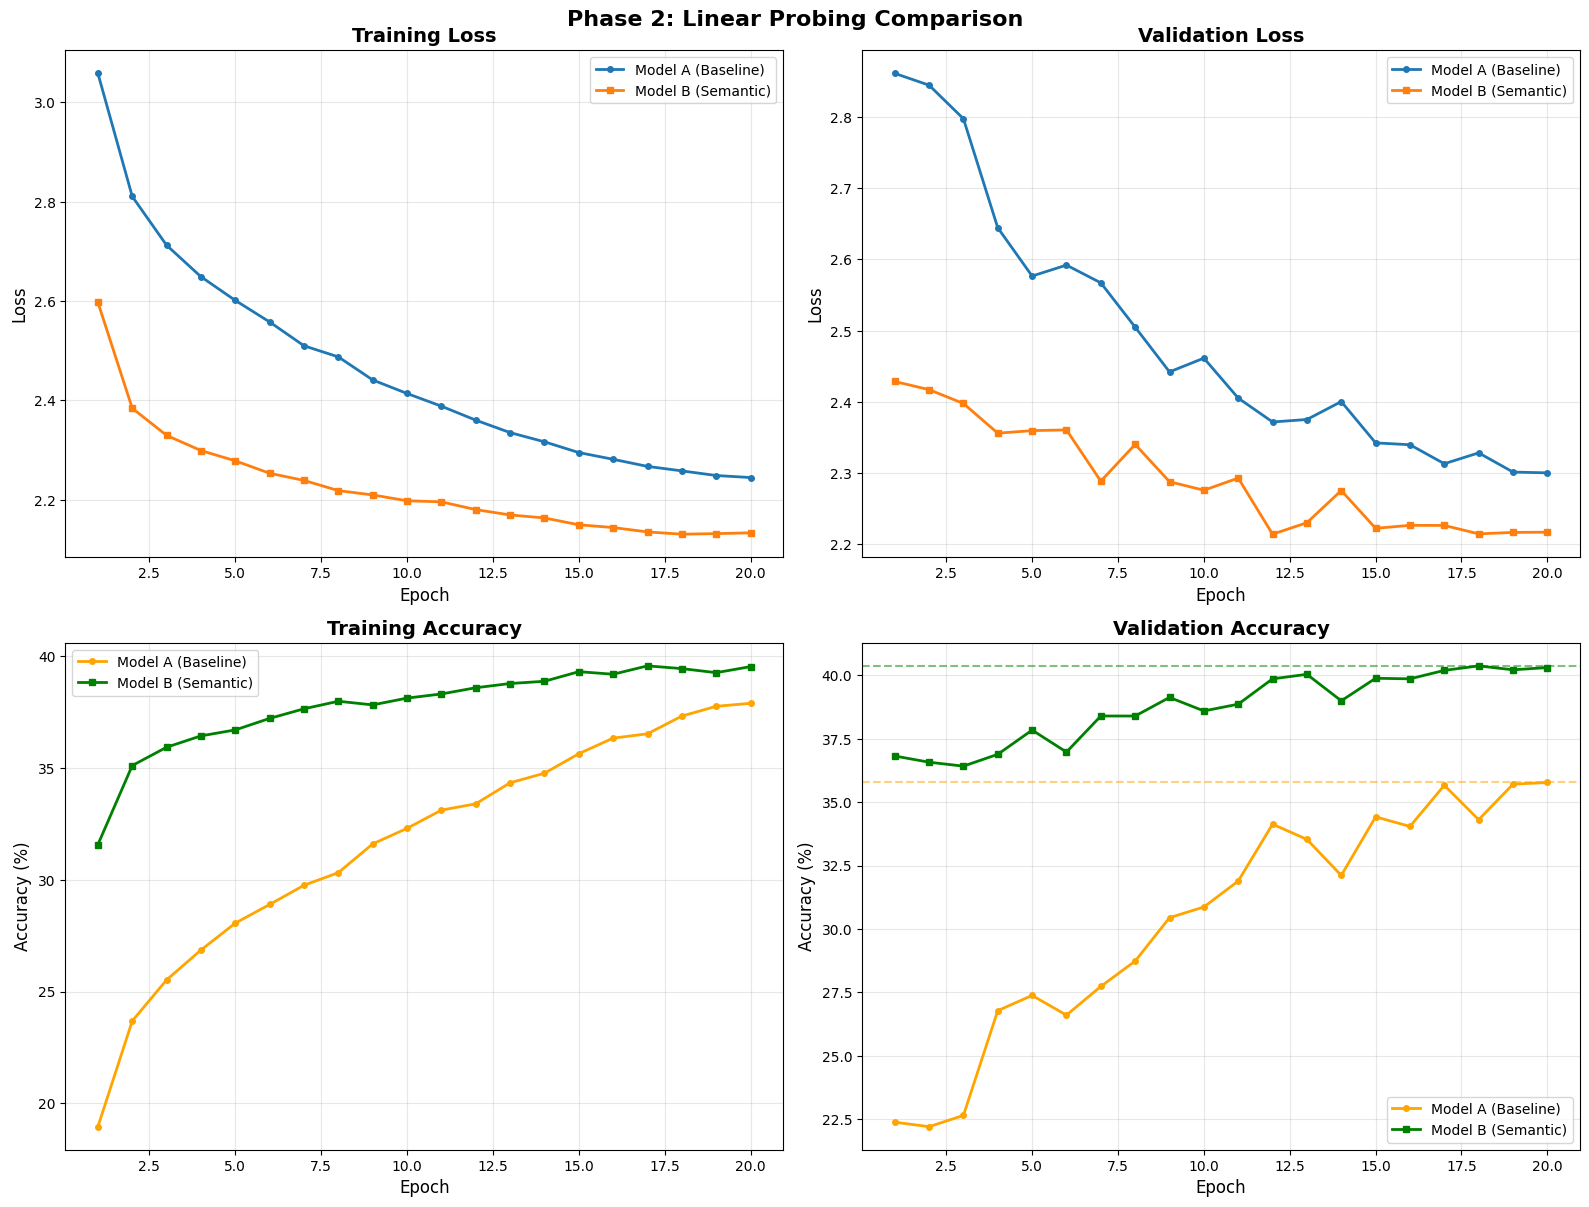

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

epochs = range(1, len(history_a['train_loss']) + 1)

# Training Loss
axes[0, 0].plot(epochs, history_a['train_loss'], 'o-', label='Model A (Baseline)', linewidth=2, markersize=4)
axes[0, 0].plot(epochs, history_b['train_loss'], 's-', label='Model B (Semantic)', linewidth=2, markersize=4)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Validation Loss
axes[0, 1].plot(epochs, history_a['val_loss'], 'o-', label='Model A (Baseline)', linewidth=2, markersize=4)
axes[0, 1].plot(epochs, history_b['val_loss'], 's-', label='Model B (Semantic)', linewidth=2, markersize=4)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].set_title('Validation Loss', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Training Accuracy
axes[1, 0].plot(epochs, history_a['train_acc'], 'o-', label='Model A (Baseline)', linewidth=2, markersize=4, color='orange')
axes[1, 0].plot(epochs, history_b['train_acc'], 's-', label='Model B (Semantic)', linewidth=2, markersize=4, color='green')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 0].set_title('Training Accuracy', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Validation Accuracy
axes[1, 1].plot(epochs, history_a['val_acc'], 'o-', label='Model A (Baseline)', linewidth=2, markersize=4, color='orange')
axes[1, 1].plot(epochs, history_b['val_acc'], 's-', label='Model B (Semantic)', linewidth=2, markersize=4, color='green')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=best_acc_a, color='orange', linestyle='--', alpha=0.5)
axes[1, 1].axhline(y=best_acc_b, color='green', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle('Phase 2: Linear Probing Comparison', fontsize=16, fontweight='bold', y=1.002)
plt.show()

## 15. Detailed Evaluation: Classification Reports

In [19]:
def evaluate_model(model, test_loader, class_names, model_name):
    """
    Evaluate model and return predictions, labels, and classification report
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f'Evaluating {model_name}'):
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Classification report
    print(f"\n{'='*70}")
    print(f"{model_name} - Classification Report")
    print('='*70)
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=3))
    
    return all_preds, all_labels

# Evaluate both models
preds_a, labels_a = evaluate_model(model_a, test_loader_phase2, train_dataset_phase2.classes, "Model A (Baseline)")
preds_b, labels_b = evaluate_model(model_b, test_loader_phase2, train_dataset_phase2.classes, "Model B (Semantic-Enhanced)")

Evaluating Model A (Baseline): 100%|██████████| 141/141 [01:16<00:00,  1.84it/s]



Model A (Baseline) - Classification Report
                       precision    recall  f1-score   support

             airplane      0.324     0.350     0.337       100
              airport      0.107     0.130     0.118       100
     baseball_diamond      0.273     0.240     0.255       100
     basketball_court      0.235     0.080     0.119       100
                beach      0.431     0.590     0.498       100
               bridge      0.281     0.250     0.265       100
            chaparral      0.690     0.600     0.642       100
               church      0.405     0.170     0.239       100
    circular_farmland      0.408     0.490     0.445       100
                cloud      0.538     0.570     0.553       100
      commercial_area      0.338     0.230     0.274       100
    dense_residential      0.466     0.480     0.473       100
               desert      0.800     0.880     0.838       100
               forest      0.468     0.730     0.570       100
          

Evaluating Model B (Semantic-Enhanced): 100%|██████████| 141/141 [01:16<00:00,  1.85it/s]


Model B (Semantic-Enhanced) - Classification Report
                       precision    recall  f1-score   support

             airplane      0.398     0.330     0.361       100
              airport      0.161     0.230     0.189       100
     baseball_diamond      0.336     0.360     0.348       100
     basketball_court      0.318     0.140     0.194       100
                beach      0.404     0.590     0.480       100
               bridge      0.302     0.390     0.341       100
            chaparral      0.882     0.670     0.761       100
               church      0.475     0.280     0.352       100
    circular_farmland      0.476     0.590     0.527       100
                cloud      0.570     0.490     0.527       100
      commercial_area      0.338     0.220     0.267       100
    dense_residential      0.528     0.670     0.590       100
               desert      0.817     0.850     0.833       100
               forest      0.693     0.790     0.738       100
 

## 16. Per-Class Accuracy Comparison

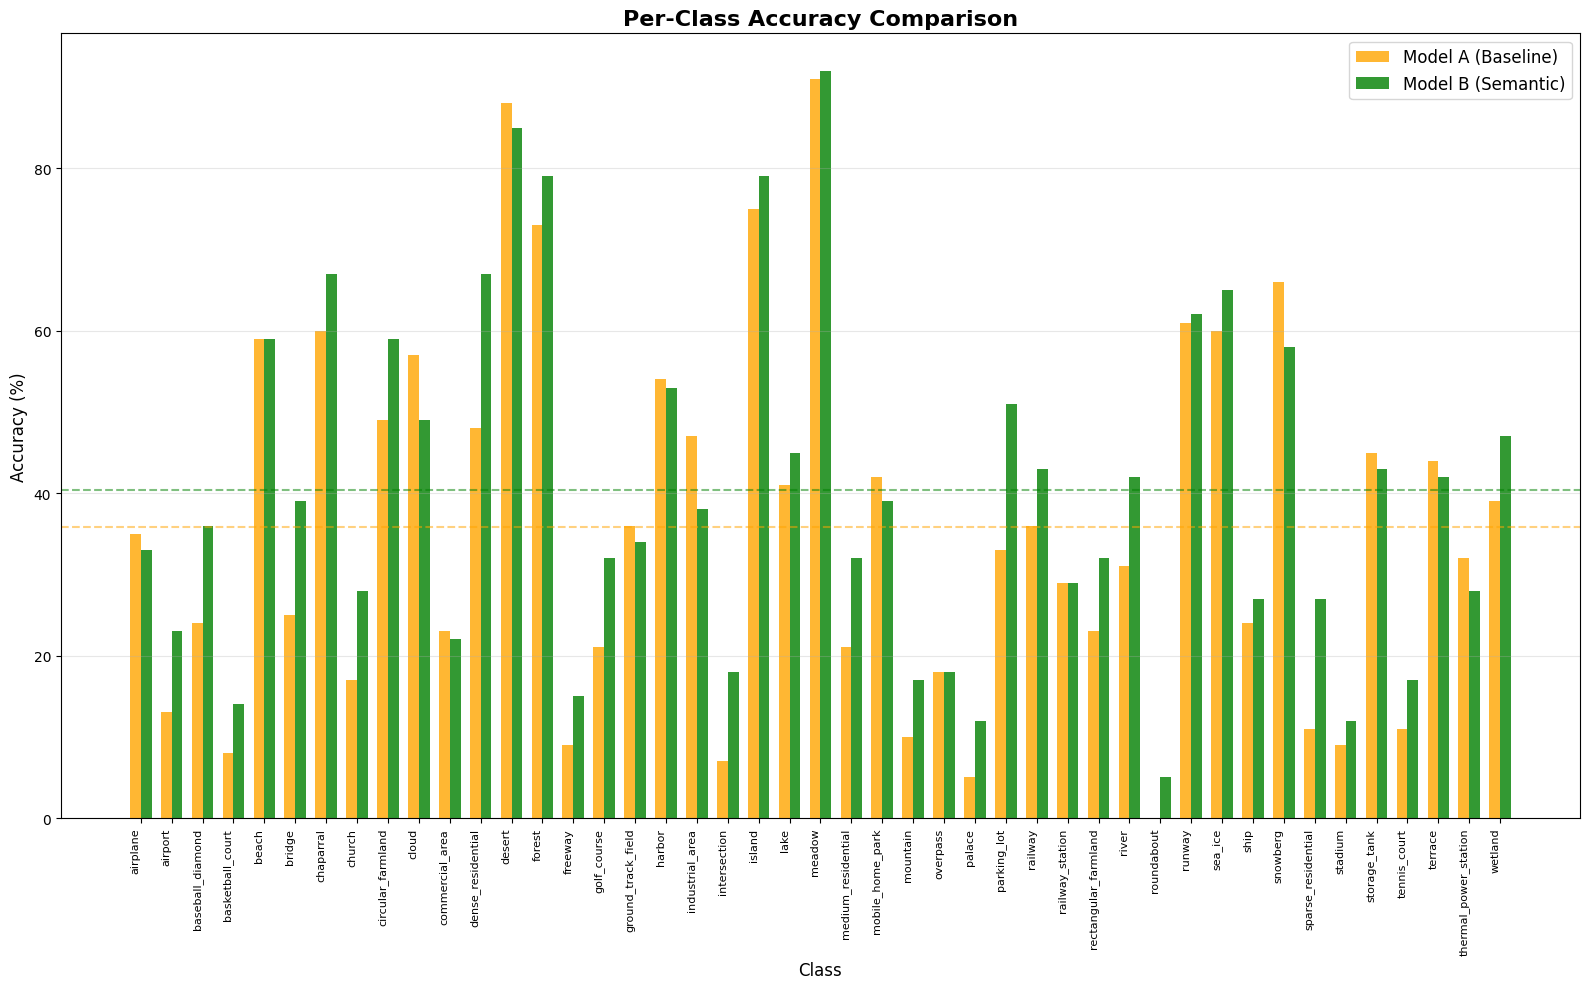


📈 Top 10 Classes with Biggest Improvements:
dense_residential              | A:  48.0% | B:  67.0% | Δ: + 19.0%
parking_lot                    | A:  33.0% | B:  51.0% | Δ: + 18.0%
sparse_residential             | A:  11.0% | B:  27.0% | Δ: + 16.0%
bridge                         | A:  25.0% | B:  39.0% | Δ: + 14.0%
baseball_diamond               | A:  24.0% | B:  36.0% | Δ: + 12.0%
church                         | A:  17.0% | B:  28.0% | Δ: + 11.0%
golf_course                    | A:  21.0% | B:  32.0% | Δ: + 11.0%
medium_residential             | A:  21.0% | B:  32.0% | Δ: + 11.0%
intersection                   | A:   7.0% | B:  18.0% | Δ: + 11.0%
river                          | A:  31.0% | B:  42.0% | Δ: + 11.0%


In [20]:
# Calculate per-class accuracy
def per_class_accuracy(labels, preds, num_classes):
    accuracies = []
    for i in range(num_classes):
        class_mask = labels == i
        if class_mask.sum() > 0:
            class_acc = (preds[class_mask] == labels[class_mask]).sum() / class_mask.sum()
            accuracies.append(class_acc * 100)
        else:
            accuracies.append(0)
    return np.array(accuracies)

acc_a = per_class_accuracy(labels_a, preds_a, num_classes)
acc_b = per_class_accuracy(labels_b, preds_b, num_classes)

# Plot comparison
fig, ax = plt.subplots(figsize=(16, 10))

x = np.arange(num_classes)
width = 0.35

bars1 = ax.bar(x - width/2, acc_a, width, label='Model A (Baseline)', alpha=0.8, color='orange')
bars2 = ax.bar(x + width/2, acc_b, width, label='Model B (Semantic)', alpha=0.8, color='green')

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Per-Class Accuracy Comparison', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(train_dataset_phase2.classes, rotation=90, ha='right', fontsize=8)
ax.legend(fontsize=12)
ax.grid(True, axis='y', alpha=0.3)
ax.axhline(y=best_acc_a, color='orange', linestyle='--', alpha=0.5, label=f'Avg A: {best_acc_a:.1f}%')
ax.axhline(y=best_acc_b, color='green', linestyle='--', alpha=0.5, label=f'Avg B: {best_acc_b:.1f}%')

plt.tight_layout()
plt.show()

# Find classes with biggest improvements
improvements = acc_b - acc_a
top_improved_idx = np.argsort(improvements)[-10:][::-1]
print("\n📈 Top 10 Classes with Biggest Improvements:")
print("="*70)
for idx in top_improved_idx:
    print(f"{train_dataset_phase2.classes[idx]:30s} | A: {acc_a[idx]:5.1f}% | B: {acc_b[idx]:5.1f}% | Δ: +{improvements[idx]:5.1f}%")

## 17. Convergence Speed Comparison

In [21]:
# Find epoch where each model reaches certain accuracy thresholds
thresholds = [50, 60, 70, 75, 80]

print("\n⚡ CONVERGENCE SPEED ANALYSIS")
print("="*70)
print("Epochs to reach accuracy thresholds:")
print("="*70)

for threshold in thresholds:
    epoch_a = next((i+1 for i, acc in enumerate(history_a['val_acc']) if acc >= threshold), "Not reached")
    epoch_b = next((i+1 for i, acc in enumerate(history_b['val_acc']) if acc >= threshold), "Not reached")
    
    print(f"\n{threshold}% Accuracy:")
    print(f"  Model A: {epoch_a if isinstance(epoch_a, str) else f'Epoch {epoch_a}'}")
    print(f"  Model B: {epoch_b if isinstance(epoch_b, str) else f'Epoch {epoch_b}'}")
    
    if not isinstance(epoch_a, str) and not isinstance(epoch_b, str):
        speedup = epoch_a - epoch_b
        if speedup > 0:
            print(f"  ✅ Model B converged {speedup} epoch(s) faster!")
        elif speedup < 0:
            print(f"  Model A converged {-speedup} epoch(s) faster")
        else:
            print(f"  Both converged at same time")
print("="*70)


⚡ CONVERGENCE SPEED ANALYSIS
Epochs to reach accuracy thresholds:

50% Accuracy:
  Model A: Not reached
  Model B: Not reached

60% Accuracy:
  Model A: Not reached
  Model B: Not reached

70% Accuracy:
  Model A: Not reached
  Model B: Not reached

75% Accuracy:
  Model A: Not reached
  Model B: Not reached

80% Accuracy:
  Model A: Not reached
  Model B: Not reached


## 18. Summary and Conclusions

In [22]:
print("\n" + "="*70)
print("📊 EXPERIMENT SUMMARY")
print("="*70)

print("\n🔬 PHASE 1: Knowledge Distillation (Unsupervised)")
print("-" * 70)
print(f"  Teacher: RemoteCLIP ViT-B/32 (frozen)")
print(f"  Student: Prithvi EO v2 (frozen) + Projection Head (trainable)")
print(f"  Training Samples: {len(unsupervised_dataset):,}")
print(f"  Epochs: {phase1_epochs}")
print(f"  Final Loss: {best_phase1_loss:.4f}")
print(f"  Final Cosine Similarity: {phase1_history['cosine_sim'][-1]:.4f}")

print("\n🔬 PHASE 2: Linear Probing (Supervised)")
print("-" * 70)
print(f"  Number of Classes: {num_classes}")
print(f"  Training Samples: {len(train_dataset_phase2):,}")
print(f"  Test Samples: {len(test_dataset_phase2):,}")
print(f"  Epochs: 20")

print("\n📈 RESULTS:")
print("-" * 70)
print(f"  Model A (Baseline - Raw Prithvi):")
print(f"    Architecture: Prithvi(frozen) → Linear(1024→45)")
print(f"    Best Val Accuracy: {best_acc_a:.2f}%")

print(f"\n  Model B (Semantic-Enhanced):")
print(f"    Architecture: Prithvi(frozen) → PH(frozen) → Linear(512→45)")
print(f"    Best Val Accuracy: {best_acc_b:.2f}%")

print(f"\n🎯 IMPROVEMENT:")
print("-" * 70)
print(f"  Absolute Gain: +{best_acc_b - best_acc_a:.2f}%")
print(f"  Relative Gain: +{((best_acc_b - best_acc_a)/best_acc_a)*100:.2f}%")

if best_acc_b > best_acc_a:
    print(f"\n✅ CONCLUSION: Semantic enhancement via RemoteCLIP alignment successfully")
    print(f"   improved classification performance!")
    print(f"\n💡 KEY INSIGHT: By teaching Prithvi to 'speak RemoteCLIP's language' through")
    print(f"   unsupervised knowledge distillation, we created features that are more")
    print(f"   semantically meaningful and easier to linearly separate for classification.")
else:
    print(f"\n⚠️  CONCLUSION: Semantic enhancement did not improve performance in this setup.")
    print(f"\n💡 POTENTIAL REASONS:")
    print(f"   - Prithvi's raw features may already be highly discriminative")
    print(f"   - Projection head may need different architecture or training")
    print(f"   - Different hyperparameters may be needed")

print("\n" + "="*70)
print("🎉 EXPERIMENT COMPLETE!")
print("="*70)


📊 EXPERIMENT SUMMARY

🔬 PHASE 1: Knowledge Distillation (Unsupervised)
----------------------------------------------------------------------
  Teacher: RemoteCLIP ViT-B/32 (frozen)
  Student: Prithvi EO v2 (frozen) + Projection Head (trainable)
  Training Samples: 27,000
  Epochs: 15
  Final Loss: 0.1846
  Final Cosine Similarity: 0.8154

🔬 PHASE 2: Linear Probing (Supervised)
----------------------------------------------------------------------
  Number of Classes: 45
  Training Samples: 27,000
  Test Samples: 4,500
  Epochs: 20

📈 RESULTS:
----------------------------------------------------------------------
  Model A (Baseline - Raw Prithvi):
    Architecture: Prithvi(frozen) → Linear(1024→45)
    Best Val Accuracy: 35.78%

  Model B (Semantic-Enhanced):
    Architecture: Prithvi(frozen) → PH(frozen) → Linear(512→45)
    Best Val Accuracy: 40.38%

🎯 IMPROVEMENT:
----------------------------------------------------------------------
  Absolute Gain: +4.60%
  Relative Gain: +12.86